# 1. Import Lib*

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology
from skimage.filters import meijering, sato, frangi
from cv2 import erode, dilate
from scipy.sparse import dok_matrix
import pandas as pd
import pandas
import networkx as nx

# 2. Import Image*

In [2]:
im = Image.open('/home/ipausers/hamzaoui/Downloads/wetransfer_louis-cohen-mfre-images_2024-06-17_0804/Image-1.tif')
imarray = np.array(im).astype(int) / (2**14 - 1)
print(imarray.shape)
print(imarray)
cmap = plt.cm.gray

(7111, 10017)
[[0.69956662 0.67039004 0.65671733 ... 0.05267655 0.         0.        ]
 [0.68754196 0.65891473 0.65159006 ... 0.05231032 0.         0.        ]
 [0.67863029 0.65647317 0.65104071 ... 0.05310383 0.         0.        ]
 ...
 [0.44283709 0.44106696 0.43160593 ... 0.08374535 0.08368431 0.08307392]
 [0.44228774 0.43252152 0.42129036 ... 0.         0.         0.        ]
 [0.43661112 0.41860465 0.41280596 ... 0.         0.         0.        ]]


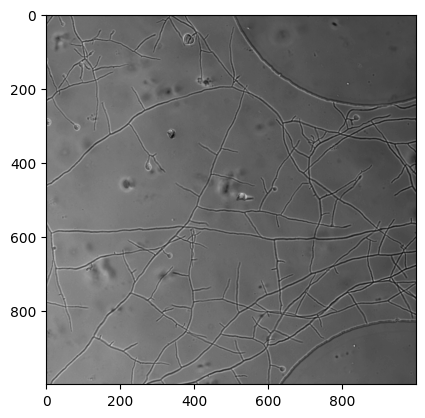

In [3]:
sampleim = imarray[2000:3000, 2000:3000]
plt.imshow(sampleim, cmap=cmap);

# 3. Skeletonize*

## 3.0 Functions*

In [10]:
def extract_branches(doc_skel):
    def get_neighbours(pixel):
        x = pixel[0]
        y = pixel[1]
        primary_neighbours = {(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)}
        secondary_neighbours = {
            (x + 1, y - 1),
            (x + 1, y + 1),
            (x - 1, y + 1),
            (x - 1, y - 1),
        }
        num_neighbours = 0
        actual_neighbours = []
        for neighbour in primary_neighbours:
            if neighbour in non_zero_pixel:
                num_neighbours += 1
                xp = neighbour[0]
                yp = neighbour[1]
                primary_neighboursp = {
                    (xp + 1, yp),
                    (xp - 1, yp),
                    (xp, yp + 1),
                    (xp, yp - 1),
                }
                for neighbourp in primary_neighboursp:
                    secondary_neighbours.discard(neighbourp)
                actual_neighbours.append(neighbour)
        for neighbour in secondary_neighbours:
            if neighbour in non_zero_pixel:
                num_neighbours += 1
                actual_neighbours.append(neighbour)
        return (actual_neighbours, num_neighbours)

    pixel_branch_dic = {pixel: set() for pixel in doc_skel.keys()}
    is_node = {pixel: False for pixel in doc_skel.keys()}
    pixel_set = set(doc_skel.keys())
    non_zero_pixel = doc_skel
    new_index = 1
    non_explored_direction = set()
    while len(pixel_set) > 0:
        is_new_start = len(non_explored_direction) == 0
        if is_new_start:
            pixel = pixel_set.pop()
        else:
            pixel = non_explored_direction.pop()
        actual_neighbours, num_neighbours = get_neighbours(pixel)
        if is_new_start:
            if num_neighbours == 2:
                new_index += 1
                pixel_branch_dic[pixel] = {new_index}
        is_node[pixel] = num_neighbours in [0, 1, 3, 4]
        pixel_set.discard(pixel)
        #!!! This is to solve the two neighbours nodes problem
        if is_node[pixel]:
            for neighbour in actual_neighbours:
                if is_node[neighbour]:
                    new_index += 1
                    pixel_branch_dic[pixel].add(new_index)
                    pixel_branch_dic[neighbour].add(new_index)
            continue
        else:
            for neighbour in actual_neighbours:
                if neighbour in pixel_set:
                    non_explored_direction.add(neighbour)
                pixel_branch_dic[neighbour] = pixel_branch_dic[neighbour].union(
                    pixel_branch_dic[pixel]
                )
    return (pixel_branch_dic, is_node, new_index)

def get_neighbours2(pixel, xs, ys):
    x = pixel[0]
    y = pixel[1]
    primary_neighbours = {(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)}
    secondary_neighbours = {
        (x + 1, y - 1),
        (x + 1, y + 1),
        (x - 1, y + 1),
        (x - 1, y - 1),
    }
    pixel_list = [(x, ys[i]) for i, x in enumerate(xs)]
    num_neighbours = 0
    actual_neighbours = set()
    for neighbour in primary_neighbours:
        if neighbour in pixel_list:
            xp = neighbour[0]
            yp = neighbour[1]
            primary_neighboursp = {
                (xp + 1, yp),
                (xp - 1, yp),
                (xp, yp + 1),
                (xp, yp - 1),
            }
            for neighbourp in primary_neighboursp:
                secondary_neighbours.discard(neighbourp)
            actual_neighbours.add(neighbour)
    for neighbour in secondary_neighbours:
        if neighbour in pixel_list:
            actual_neighbours.add(neighbour)
    return actual_neighbours

def order_pixel(pixel_begin, pixel_end, pixel_list):
    ordered_list = [pixel_begin]
    current_pixel = pixel_begin
    precedent_pixel = pixel_begin
    xs = [pixel[0] for pixel in pixel_list]
    ys = [pixel[1] for pixel in pixel_list]

    while current_pixel != pixel_end:
        neighbours = get_neighbours2(current_pixel, np.array(xs), np.array(ys))
        neighbours.discard(precedent_pixel)
        precedent_pixel = current_pixel
        current_pixel = neighbours.pop()
        ordered_list.append(current_pixel)
    return ordered_list

def from_sparse_to_graph(doc_skel):
    column_names = ["origin", "end", "pixel_list"]
    graph = pd.DataFrame(columns=column_names)
    pixel_branch_dic, is_node, new_index = extract_branches(doc_skel)
    nodes = []
    edges = {}
    for pixel in pixel_branch_dic:
        for branch in pixel_branch_dic[pixel]:
            right_branch = branch
            if right_branch not in edges.keys():
                edges[right_branch] = {"origin": [], "end": [], "pixel_list": [[]]}
            if is_node[pixel]:
                if len(edges[right_branch]["origin"]) == 0:
                    edges[right_branch]["origin"] = [pixel]
                else:
                    edges[right_branch]["end"] = [pixel]
            edges[right_branch]["pixel_list"][0].append(pixel)
    for branch in edges:
        if len(edges[branch]["origin"]) > 0 and len(edges[branch]["end"]) > 0:
            # TODO(FK): Use pandas.concat instead (Frame.append soon deprecated)
            # graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)
            graph = pandas.concat([graph, pd.DataFrame(edges[branch])])
    for index, row in graph.iterrows():
        row["pixel_list"] = order_pixel(row["origin"], row["end"], row["pixel_list"])
    return graph

def generate_set_node(graph_tab):
    nodes = set()
    for index, row in graph_tab.iterrows():
        nodes.add(row["origin"])
        nodes.add(row["end"])
    return sorted(nodes)


def generate_nx_graph(graph_tab, labeled=False):
    G = nx.Graph()
    pos = {}
    if not labeled:
        nodes = generate_set_node(graph_tab)
    for index, row in graph_tab.iterrows():
        if labeled:
            identifier1 = row["origin_label"]
            identifier2 = row["end_label"]
            pos[identifier1] = np.array(row["origin_pos"]).astype(np.int32)
            pos[identifier2] = np.array(row["end_pos"]).astype(np.int32)
        else:
            identifier1 = nodes.index(row["origin"])
            identifier2 = nodes.index(row["end"])
            pos[identifier1] = np.array(row["origin"]).astype(np.int32)
            pos[identifier2] = np.array(row["end"]).astype(np.int32)
        info = {"weight": len(row["pixel_list"]), "pixel_list": row["pixel_list"]}
        G.add_edges_from([(identifier1, identifier2, info)])
    return (G, pos)

## 3.1 Sample

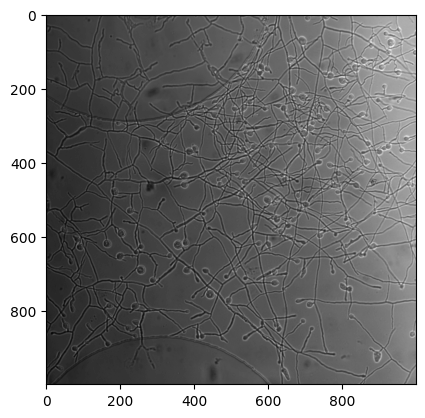

In [41]:
sampleim = imarray[3500:4500, 0:1000]
plt.imshow(sampleim, cmap=cmap);

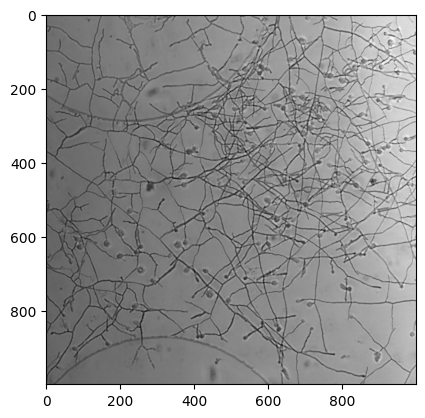

In [42]:
sampleimth = sampleim - morphology.white_tophat(sampleim, morphology.disk(2))
sampleimth = sampleimth - morphology.black_tophat(sampleimth, morphology.disk(10))
plt.imshow(sampleimth, cmap=cmap);

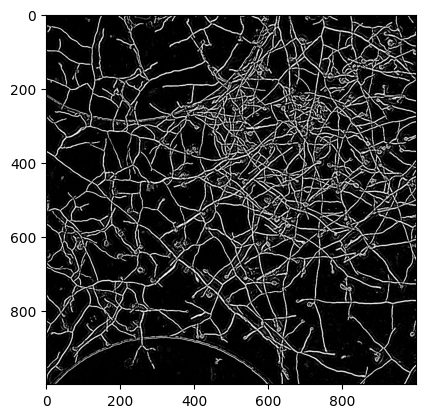

In [43]:
samplefrangiim = frangi(sampleimth, gamma=0.01)
plt.imshow(samplefrangiim, cmap=cmap);

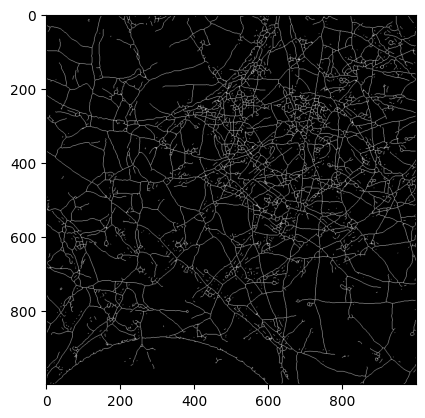

In [44]:
new_im = np.where(samplefrangiim>0.5, 1, 0).astype(np.uint8)
new_im = dilate(new_im, np.ones((3, 3)), iterations=1)
new_im = morphology.skeletonize(new_im).astype(np.uint8)
plt.imshow(new_im, cmap=cmap);

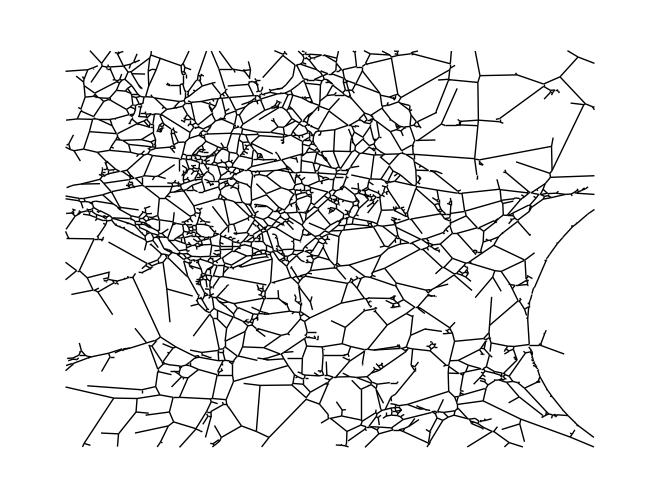

In [36]:
skeleton_sample = dok_matrix(new_im)
graph_sample, pos_sample = generate_nx_graph(from_sparse_to_graph(skeleton_sample))
Gcc = sorted(nx.connected_components(graph_sample), key=len, reverse=True)
G0 = graph_sample.subgraph(Gcc[0])
nx.draw(G0, pos_sample, node_size=0)

## 3.2 Full Image*

In [20]:
side = 1000
margin = 100

print(imarray.shape[0], imarray.shape[1])
rows = []
for i in range(margin, imarray.shape[0]-side-margin, side):
    row = []
    for j in range(margin, imarray.shape[1]-side-margin, side):
        print(i, j)
        sample = imarray[i-margin:i+side+margin, j-margin:j+side+margin]
        sampleimth = sample - morphology.white_tophat(sample, morphology.disk(2))
        sampleimth = sampleimth - morphology.black_tophat(sampleimth, morphology.disk(10))
        frangisample = frangi(sampleimth, gamma=0.01)
        new_im = np.where(frangisample>0.5, 1, 0).astype(np.uint8)
        new_im = dilate(new_im, np.ones((3, 3)), iterations=1)
        new_im = new_im[margin:side+margin, margin:side+margin]
        row.append(new_im)
    rows.extend(np.concatenate(row, axis=1))
frangiim = np.array(rows)
skeleton = morphology.skeletonize(frangiim)

7111 10017
100 100


KeyboardInterrupt: 

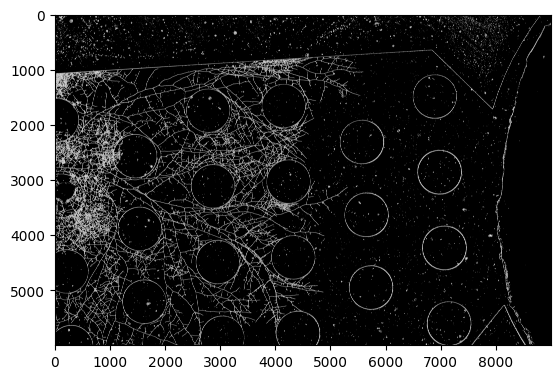

In [21]:
plt.imshow(frangiim, cmap=cmap);

## 3.3 Save Image

### Save previous

In [65]:
im_to_save = 1-frangiim
frangi_pil = Image.fromarray(255*(im_to_save.astype(np.uint8))) 
frangi_pil.save("/home/ipausers/hamzaoui/Documents/Data/Louis_Segmentation/hat_berfore_frangi.jpeg")

### Erode for good volume

In [66]:
im_to_save = 1-erode(frangiim, np.ones((3, 3)), iterations=1)
frangi_pil = Image.fromarray(255*(im_to_save.astype(np.uint8))) 
frangi_pil.save("/home/ipausers/hamzaoui/Documents/Data/Louis_Segmentation/hat_berfore_frangi_good_volume.jpeg")

### Skeleton

In [70]:
im_to_save = 1-skeleton
frangi_pil = Image.fromarray(255*(im_to_save.astype(np.uint8))) 
frangi_pil.save("/home/ipausers/hamzaoui/Documents/Data/Louis_Segmentation/hat_berfore_frangi_skeleton.jpeg")

### Bowler hat only

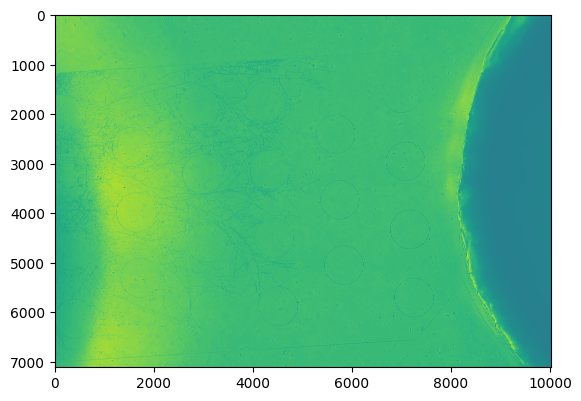

In [75]:
im_to_save = imarray - morphology.white_tophat(imarray, morphology.disk(2))
im_to_save = im_to_save - morphology.black_tophat(im_to_save, morphology.disk(10))
plt.imshow(im_to_save, cmap=cmap)
frangi_pil = Image.fromarray((255*im_to_save).astype(np.uint8)) 
frangi_pil.save("/home/ipausers/hamzaoui/Documents/Data/Louis_Segmentation/hat_only.jpeg")

# 4. To Graph*

## 4.1 Create Graph*

In [57]:
skeleton_dok = dok_matrix(skeleton)
graph, pos = generate_nx_graph(from_sparse_to_graph(skeleton_dok))

## 4.2 Select Major connected component*

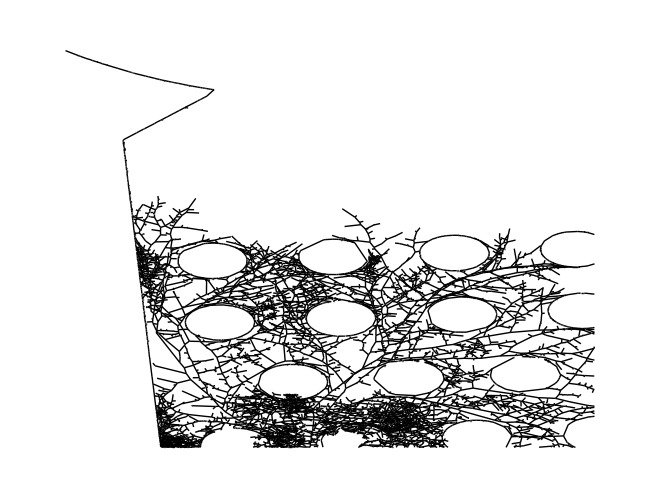

In [58]:
Gcc = sorted(nx.connected_components(graph), key=len, reverse=True)
G0 = graph.subgraph(Gcc[0])
nx.draw(G0, pos, node_size=0)

In [61]:
im_arr = np.zeros((6000, 9000))
for u, v, e in G0.edges(data=True):
    pixels = e['pixel_list']
    for (x, y) in pixels:
        im_arr[x][y] = 1

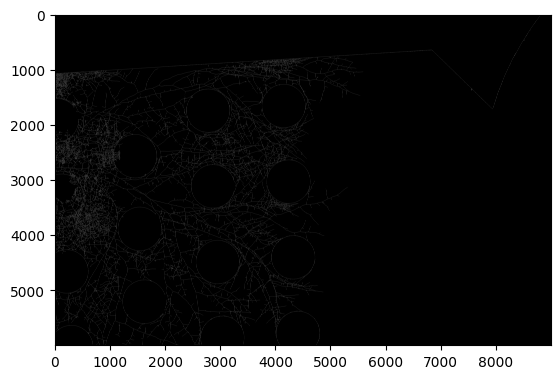

In [62]:
plt.imshow(im_arr, cmap=cmap)

In [68]:
im_to_save = 1-im_arr
frangi_pil = Image.fromarray(255*(im_to_save.astype(np.uint8))) 
frangi_pil.save("/home/ipausers/hamzaoui/Documents/Data/Louis_Segmentation/hat_berfore_frangi_final.jpeg")